# Network Subgroups
Finding subgroups in your network

## Import library and define auxiliary functions

In [1]:
import sys
import os

import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import collections

import community as louvain #from python-louvain

In [2]:
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from graphutil.visualization import draw_graph_and_color_groups
from graphutil.print import print_network_information

## Connected Components

Information for given Graph with name '':
	Graph is directed: True
	Number of nodes: 8
	Number of edges: 11


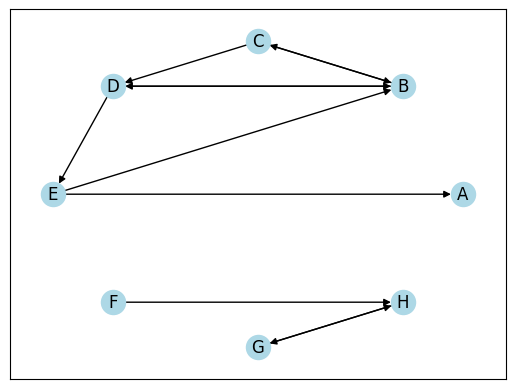

In [4]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
G.add_edges_from([('B', 'C'), ('B', 'D'),
                  ('C', 'B'), ('C', 'D'),
                  ('D', 'E'), ('D', 'B'),
                  ('E', 'A'), ('E', 'B'),
                  ('F', 'H'),
                  ('G', 'H'),
                  ('H', 'G'),
                 ])
print_network_information(G)
nx.draw_networkx(G, pos= nx.drawing.layout.circular_layout(G), node_color="lightblue")

### Strongly connected components
Connectivity 

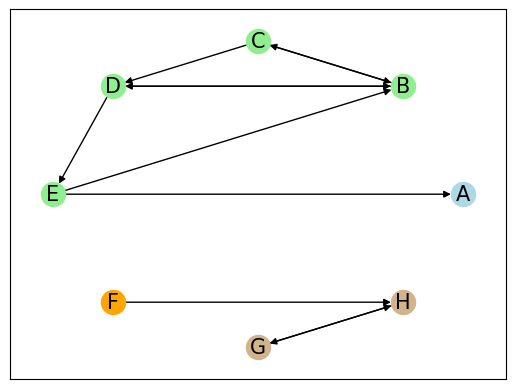

In [5]:
strongly_connected_components = nx.strongly_connected_components(G)
draw_graph_and_color_groups(G, strongly_connected_components)

### Weakly connected components
A directed Graph must be transformed to an undirected in order to calculate the weakly connected components in networkX

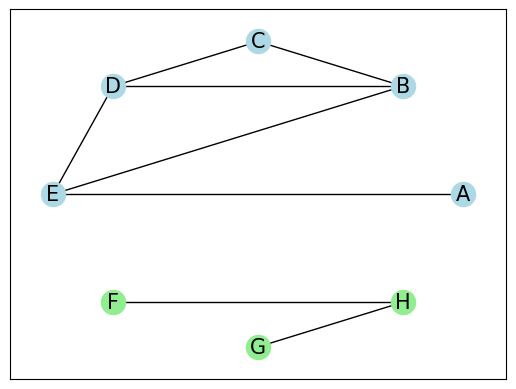

In [6]:
G_undirected = G.to_undirected()
weakly_connected_components = nx.connected_components(G_undirected)
draw_graph_and_color_groups(G_undirected, weakly_connected_components)

### Giant Component
Find Largest Strongly Connected Component and then create a subgraph (filtering all the other nodes and edges pointing to nodes outside of the giant component)

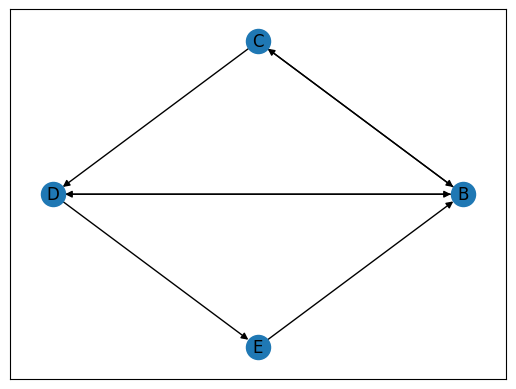

In [7]:
largest_scc = max(nx.strongly_connected_components(G), key=len)
giant_component = nx.subgraph(G, largest_scc)
nx.draw_networkx(giant_component, pos= nx.drawing.layout.circular_layout(giant_component))

## k-Core
Calculating k-core is also efficient on very large graphs (especially compared to other clustering algorithms). It takes O(m) where m is the number of edges.

In [8]:
G = nx.Graph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
G.add_edges_from([('A', 'B'), ('A', 'C'), ('A', 'D'),
                 ('B', 'C'), ('B', 'D'),
                 ('C', 'D'),
                 ('E', 'D'), ('E', 'F'), ('E', 'G'),
                 ('F', 'G')])

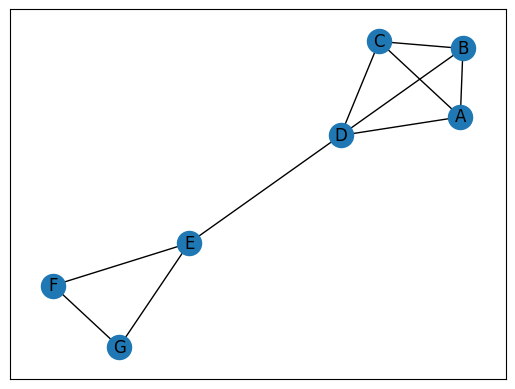

In [9]:
nx.draw_networkx(G)

In [10]:
nx.core_number(G)

{'A': 3, 'B': 3, 'C': 3, 'D': 3, 'E': 2, 'F': 2, 'G': 2}

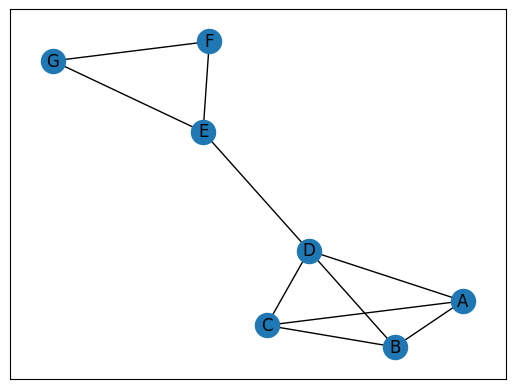

In [11]:
core_subgraph = nx.k_core(G, 2)
nx.draw_networkx(core_subgraph)

## Communities
Community detection algorithms must be imported additionally using:

```from networkx.algorithms import community```

### Girvan Newman Clustering (Edge Betweenness Clustering)

In [12]:
G = nx.Graph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
G.add_edges_from([('A', 'B'), 
                  ('B', 'C'), ('B', 'D'), ('B', 'E'), 
                  ('D', 'E'), ('D', 'F'), ('D', 'G'), 
                  ('F', 'G'), ('F', 'H')
                 ])

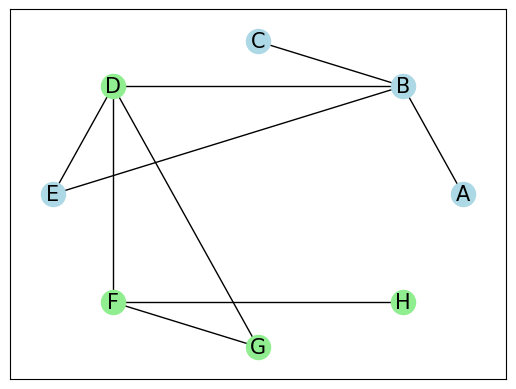

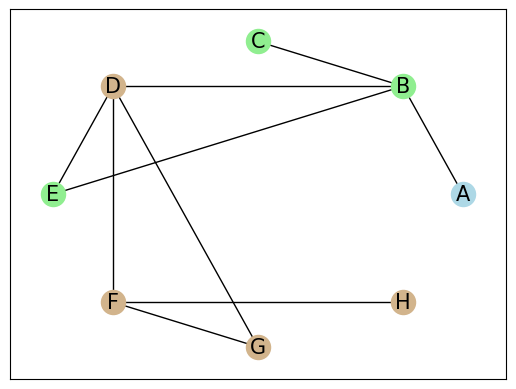

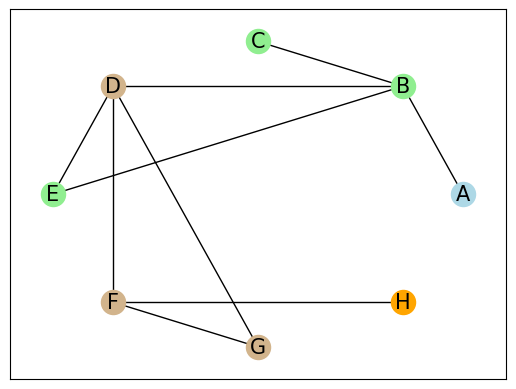

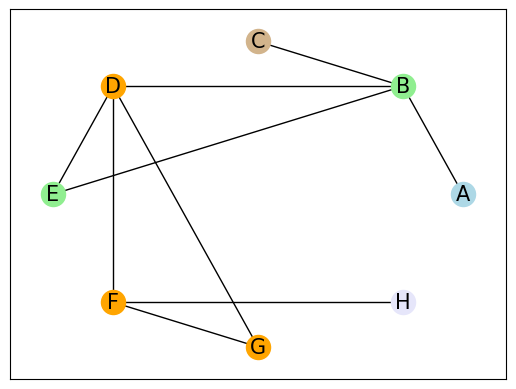

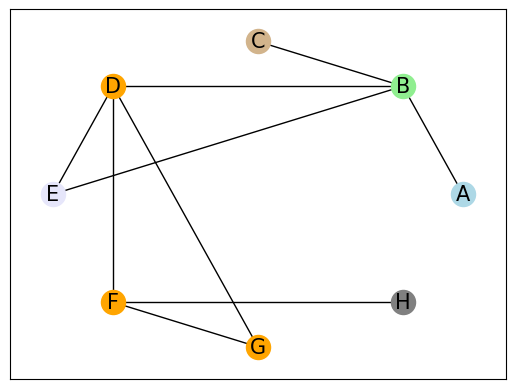

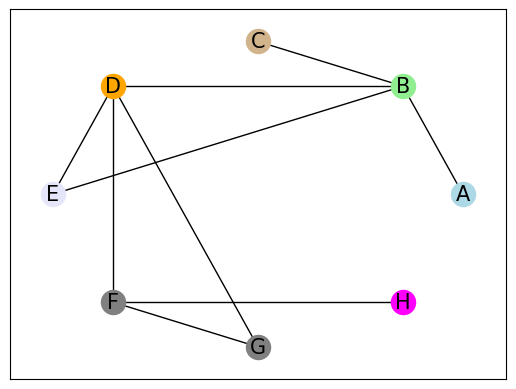

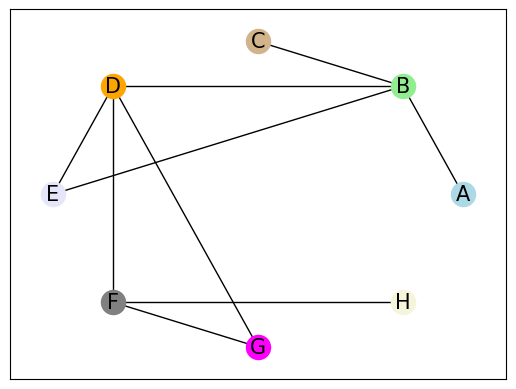

In [13]:
# Edge-Betweenness-Clustering
edge_betw_communities = list(community.girvan_newman(G))
num_steps = len(edge_betw_communities)

for i, step in enumerate(edge_betw_communities):
    plt.figure(i)
    draw_graph_and_color_groups(G, step)

## Label propagation

Show initial graph coloring

Initial state
{'B': 0, 'D': 1, 'F': 0, 'E': 2, 'G': 2, 'A': 1, 'C': 1, 'H': 1}
defaultdict(<class 'set'>, {0: {'F', 'B'}, 1: {'D', 'A', 'H', 'C'}, 2: {'E', 'G'}})


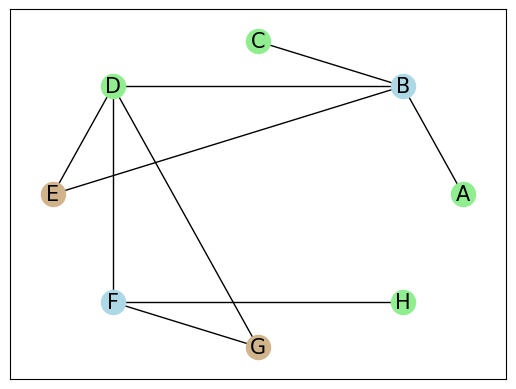

In [14]:
colors = nx.greedy_color(G)
inv_map = collections.defaultdict(set)
for node, color in colors.items():
    inv_map[color].add(node)
print("Initial state")
print(colors)
print(inv_map)
draw_graph_and_color_groups(G, inv_map.values())

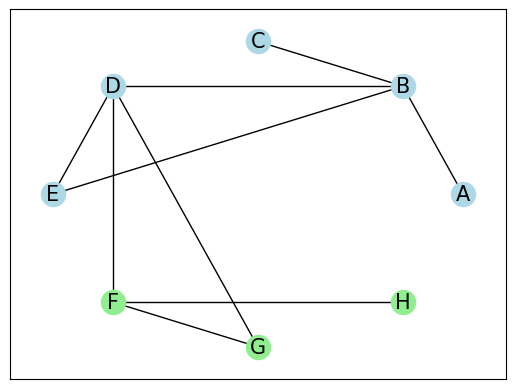

In [15]:
# label Propagation
label_communities = community.label_propagation_communities(G)
draw_graph_and_color_groups(G, label_communities)

### Modularity based clustering
#### NetworkX Greedy Modularity

In [16]:
G.edges(data=True)

EdgeDataView([('A', 'B', {}), ('B', 'C', {}), ('B', 'D', {}), ('B', 'E', {}), ('D', 'E', {}), ('D', 'F', {}), ('D', 'G', {}), ('F', 'G', {}), ('F', 'H', {})])

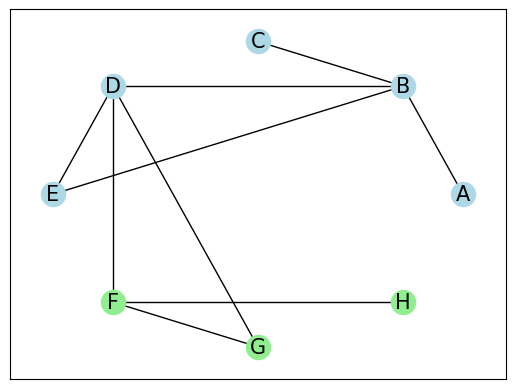

In [17]:
# Modularity
mod_communities = community.naive_greedy_modularity_communities(G)
draw_graph_and_color_groups(G, mod_communities)


#### Louvain

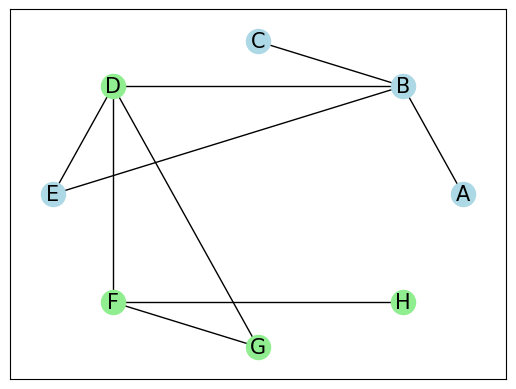

In [18]:
louv_communities = louvain.best_partition(G)

partitions = dict()
for k,v in louv_communities.items():
    partitions.setdefault(v, []).append(k)

draw_graph_and_color_groups(G, partitions.values())


### Comparing performance of different community detection algorithms

In [19]:
num_nodes = 10000
probability = 0.001
performance_graph = nx.erdos_renyi_graph(num_nodes, probability, seed=42)
print_network_information(performance_graph)

Information for given Graph with name '':
	Graph is directed: False
	Number of nodes: 10000
	Number of edges: 49722


In [20]:
%%time
subgraph = nx.k_core(performance_graph, 2)
print(subgraph.number_of_nodes())
print("Finished 2-core")

9999
Finished 2-core
CPU times: total: 203 ms
Wall time: 396 ms


In [21]:
%%time
# label Propagation
clusters = list(community.label_propagation_communities(performance_graph))
print("Finished Label Propagation")

Finished Label Propagation
CPU times: total: 328 ms
Wall time: 448 ms


In [22]:
%%time
_ = list(community.greedy_modularity_communities(performance_graph))
print("Finished Modularity Clustering")

Finished Modularity Clustering
CPU times: total: 1min 9s
Wall time: 1min 21s


In [23]:
%%time
_ = list(louvain.best_partition(performance_graph))
print("Finished Louvain Clustering")

Finished Louvain Clustering
CPU times: total: 10.4 s
Wall time: 12.2 s
